## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №26

#### Прогноз просрочки кредита заемщиком

Необходимо решить задачу просрочки кредита используя для прогназирования нейронные сети. Рассмотреть работу с несбалансированными данными.  

Набор данных представляет собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ).  
Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from math import nan

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

import scikeras
from scikeras.wrappers import KerasClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

RANDOM_STATE = 42

In [2]:
print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Cuda version: 2.10.1
Num GPUs Available:  1


In [3]:
df = pd.read_csv('cs-training.csv', index_col=0)

col_dict = {
    # Целевая метка (1/0): будет ли просрочка платежей более 90 дней в ближайшие 2 года, Да/Нет
    'SeriousDlqin2yrs':'Delinquency',  
    # Баланс по кредитам (%): сумма всех кредитов за исключением недвижимости и рассрочек(автокредиты), разделенная на сумму кредитных лимитов
    'RevolvingUtilizationOfUnsecuredLines':'CreditBalance',
    # Возраст заемщика (лет)
    'age':'Age',
    # Количество просрочек платежей за последние 2 года: от 30 до 59 дней
    'NumberOfTime30-59DaysPastDueNotWorse':'Delay30_59',
    # Коэффициент задолженности (%): отношение суммы ежемесячных платежей (долги, алименты, проживание) к месячному доходу
    'DebtRatio':'DebtRatio',
    # Mесячный доход ($)
    'MonthlyIncome':'MonthlyIncome',
    # Количество открытых кредитов (рассрочек) и кредитных линий (кредитные карты)
    'NumberOfOpenCreditLinesAndLoans':'CreditLineNum',
    # Количество просрочек платежей за последние 2 года: 90 дней и больше
    'NumberOfTimes90DaysLate':'Delay90',
    # Количество открытых кредитов на недвижимость, включая кредитные линии под залог жилья
    'NumberRealEstateLoansOrLines':'EstateLoanNum',
    # Количество просрочек платежей за последние 2 года: от 60 до 89 дней
    'NumberOfTime60-89DaysPastDueNotWorse':'Delay60_89',
    # Количество иждивенцев в семье (исключая заемщика)
    'NumberOfDependents':'Dependents'
} 

df.columns = [col_dict.get(x,x) for x in df.columns]

df = df[['Age','Dependents','MonthlyIncome','DebtRatio','CreditBalance','CreditLineNum','EstateLoanNum','Delay30_59','Delay60_89','Delay90','Delinquency']]

Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [4]:
# Для признака Dependents заменить все пустые значения на -1
df['Dependents'].fillna(-1, inplace=True)
# Для признака MonthlyIncome заменить все пустые значения на 0
df['MonthlyIncome'].fillna(0, inplace=True)

print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 648
Набор данных после удаления дубликатов: (149352, 11)


Построить корреляционную матрицу признаков  
Проанализировать зависимости

In [ ]:
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается незначительная отрицательная корреляция (-0.22) признаков возраста (Age) и количества иждивенцев (Dependents)
- Наблюдается существенная положительная корреляция (0.43) между собой признаков количества открытых кредитов (CreditLineNum и EstateLoanNum)
- Наблюдается сильная корреляция (0.98 - 0.99) между собой признаков наличия просрочек платежей за различные периоды (Delay30_59, Delay60_89, Delay90)

In [5]:
# Заменить признаки CreditLineNum и EstateLoanNum на суммарный признак CreditNum
df.insert(7,'CreditNum', df.CreditLineNum + df.EstateLoanNum)
df.drop(['CreditLineNum','EstateLoanNum'], axis=1, inplace=True)

# Заменить признаки Delay30_59, Delay60_89 и Delay90 на суммарный признак DelayNum
df.insert(9,'DelayNum', df.Delay30_59 + df.Delay60_89 + df.Delay90)
df.drop(['Delay30_59','Delay60_89','Delay90'], axis=1, inplace=True)

In [6]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
Age,149352.0,52.310153,14.722797,0.0,41.000000,52.000000,63.000000,109.0
Dependents,149352.0,0.714935,1.136387,-1.0,0.000000,0.000000,1.000000,20.0
MonthlyIncome,149352.0,5370.845780,13176.007265,0.0,1600.000000,4400.000000,7400.000000,3008750.0
DebtRatio,149352.0,354.529267,2042.102001,0.0,0.177571,0.368293,0.875665,329664.0
CreditBalance,149352.0,6.072551,250.296329,0.0,0.030150,0.154239,0.556414,50708.0
CreditNum,149352.0,9.505444,5.714916,0.0,5.000000,9.000000,13.000000,112.0
DelayNum,149352.0,0.840792,11.384862,0.0,0.000000,0.000000,0.000000,294.0
Delinquency,149352.0,0.067009,0.250039,0.0,0.000000,0.000000,0.000000,1.0


Визуализировать аномальные значения признаков

In [ ]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [7]:
# Заменить нулевые значения возраста медианным значением
df['Age'].replace(0, df['Age'].median(), inplace=True) 

# Удалить записи с аномальными значениями признаков
df.drop(df[df.Dependents > 15].index, inplace=True)
df.drop(df[df.MonthlyIncome > 200000.0].index, inplace=True)
df.drop(df[df.DebtRatio > 22000.0].index, inplace=True)
df.drop(df[df.CreditBalance > 8000.0].index, inplace=True)
df.drop(df[df.CreditNum > 55].index, inplace=True)
df.drop(df[df.DelayNum > 50].index, inplace=True)

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [8]:
# Подсчитать количество уникальных значений по столбцам
df.nunique(axis=0)

Age                  85
Dependents           13
MonthlyIncome     13560
DebtRatio        114075
CreditBalance    125638
CreditNum            55
DelayNum             20
Delinquency           2
dtype: int64

In [9]:
df.head()

,Age,Dependents,MonthlyIncome,DebtRatio,CreditBalance,CreditNum,DelayNum,Delinquency
1,45,2.0,9120.0,0.802982,0.766127,19,2,1
2,40,1.0,2600.0,0.121876,0.957151,4,0,0
3,38,0.0,3042.0,0.085113,0.658180,2,2,0
4,30,0.0,3300.0,0.036050,0.233810,5,0,0
5,49,0.0,63588.0,0.024926,0.907239,8,1,0


Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [10]:
# Ваш код здесь
df['Delinquency'].value_counts()

0    139162
1      9862
Name: Delinquency, dtype: int64

Данные сильно несбалансированы. В качестве метрик лучше использовать `f1_score`, `roc_auc_score`. 

__Предобработка данных__

Выберите способ нормализации. Подготовьте данные для обучения выбранных моделей...

In [11]:
feat_cols = df.columns[:-1]

#scaler = MinMaxScaler()
scaler = StandardScaler()

df[feat_cols] = scaler.fit_transform(df[feat_cols])

X = df[feat_cols]
y = df['Delinquency']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [12]:
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [29]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    #tf.keras.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(X_train.shape[1], input_shape=X_train.shape[1:], activation='relu'),
    #tf.keras.layers.Dense(512, kernel_initializer='uniform', activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=keras.metrics.AUC())

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        min_delta=1e-2,
        patience=5,
        verbose=1
    )
]

#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, batch_size=128, epochs=25,
                        #callbacks=callbacks, 
                        validation_split=0.2, verbose=0)

print('Model summary:')
print(model.summary())

print('\nModel history:')
print(history.history.keys())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None

Model history:
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


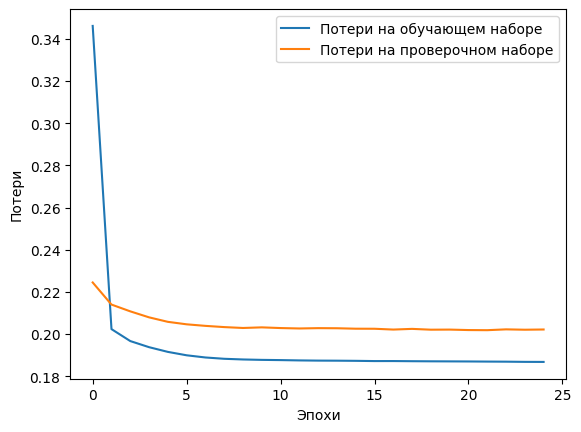

In [30]:
plt.plot(history.history['loss'], label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

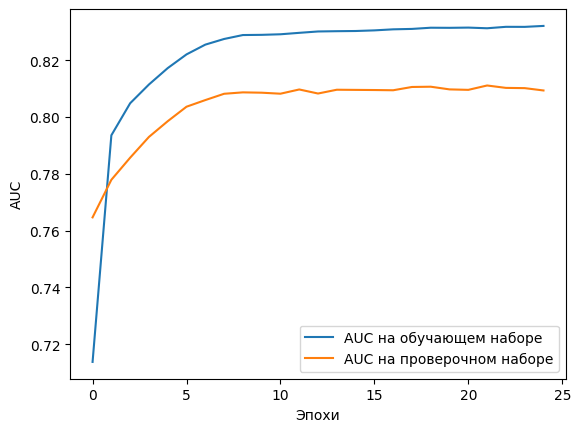

In [31]:
plt.plot(history.history['auc'], label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], label='AUC на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [32]:
scores = model.evaluate(X_test, y_test, verbose=0)

print("AUC работы на тестовых данных: %.2f%%" % (scores[1]*100))

AUC работы на тестовых данных: 81.97%


Выполним подбор гиперпараметров модели

In [13]:
tf.keras.backend.clear_session()

def get_model(optimizer ='sgd', init='glorot_uniform'):
    model = tf.keras.models.Sequential([
        #tf.keras.Input(shape=X_train.shape[1:]),
        tf.keras.layers.Dense(X_train.shape[1], activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(1, kernel_initializer=init, activation="sigmoid")
    ])
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  metrics=keras.metrics.AUC(),
                  optimizer=optimizer)
    return model

estimator = KerasClassifier(build_fn=get_model,verbose=0)

params = {
    'optimizer': ['adam','rmsprop','sgd'],
    'epochs': np.array([25]),
    'batch_size': np.array([16, 32, 64, 128]),
    #'init': ['glorot_uniform','normal','uniform']
}

scv_model = RandomizedSearchCV(estimator=estimator, param_distributions= params)

scv_result = scv_model.fit(X,y)

print("Best:%f using %s"%(scv_result.best_score_, scv_result.best_params_))

Best:0.936446 using {'optimizer': 'adam', 'epochs': 25, 'batch_size': 128}


In [19]:
print("Best score: %f \n using %s"%(scv_result.best_score_, scv_result.best_params_))

Best score: 0.936446 
 using {'optimizer': 'adam', 'epochs': 25, 'batch_size': 128}


Применим кросс-валидацию

In [20]:
tf.keras.backend.clear_session()

def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X_train.shape[1], activation="relu", input_shape=X_train.shape[1:]),
        #tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=keras.metrics.AUC())
    return model

kc_model = KerasClassifier(
    model = get_model,
    epochs=25, batch_size=128, verbose=0)

kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=RANDOM_STATE)

kc_results = cross_val_score(kc_model, X_train, y_train, cv=kfold)

print(kc_results)

[0.93513465 0.935582   0.93844502 0.93477677 0.93620828 0.93415049
 0.93549253 0.93719245 0.93494989 0.93799213]
